In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Read in network embedding and price labels

In [2]:
# Network embedding generated by GLACE
ps = pd.read_pickle('GLACE/emb/glace_cora_ml_embedding_first-order.pkl')
len(ps["mu"])

1167

In [3]:
ps

{'mu': {0: array([ 1.3808693 , -0.21439849, -0.35281137, -0.10673156,  0.25545806,
          0.79914033,  0.7082906 , -0.18687455,  1.0827888 ,  0.00348065,
         -0.1792134 , -1.2051821 ,  0.94677   , -0.60613465, -0.05518001,
          0.11263034, -0.02838498, -0.7883039 ,  1.0506712 ,  1.4673152 ,
         -1.3425914 ,  1.0912248 ,  0.8930734 ,  1.4258406 ,  1.1660123 ,
          0.01489902, -0.6752121 ,  0.30281672, -0.41345546,  0.2502417 ,
          0.8489833 , -0.13874651, -0.31543303, -1.3250506 , -1.0606912 ,
          0.5031488 , -0.17241755,  0.16250443, -1.6810249 ,  1.3886235 ,
          0.34359598, -1.035201  , -1.5522715 ,  0.28412348,  1.1080968 ,
          1.3777301 , -0.7786546 , -0.255015  , -0.21402888,  0.03924662,
         -0.5584393 , -0.13176702, -0.4359856 ,  0.29610175, -0.46475875,
         -0.89420754, -0.07248361,  0.23286423,  0.08661067, -0.45594117,
          0.38887393, -0.34728903,  0.1094037 ,  0.66713417], dtype=float32),
  1: array([ 1.3731595 , 

In [11]:
# Example of the content of the network embedding for node 2.
print("mu of node 2: ", ps["mu"][2])
print(100*"*")
print("sigma of node 2: ", ps["sigma"][2])

mu of node 2:  [ 1.1219455   0.8957876  -1.0212011   0.9573404   1.2778492   1.1782261
 -0.8505197   1.0828797   0.66093516  1.0573201   0.9836294   1.1308503
 -0.620148   -1.3031708  -0.75431705 -0.6160234  -1.1136093  -0.9388194
 -0.9545261  -1.0572796   1.2893603  -0.749675    0.5449898   1.1955999
  1.0922259   1.2448739   1.1517192   0.9952309  -1.2936085  -1.3820841
  1.1183423  -1.1370598   1.0901617  -1.2930392   1.1508017   0.7545409
 -1.0092317  -0.8983233  -0.8680123  -0.79145205  1.194396    1.0899092
  1.0760761   1.2668289  -1.2362025  -0.7802969   1.2225193  -0.8764839
  0.8847276  -1.3238096  -0.6570203   1.0390604   0.69118446  0.06309837
 -1.3174437   1.1343174  -0.516103   -1.4234776  -0.5350549   1.3673124
 -0.69810915  1.2048788  -1.3479466   0.9477263 ]
****************************************************************************************************
sigma of node 2:  [2.4033123e+01 2.3992476e+01 2.4018513e+01 2.4098574e+01 2.4507248e+01
 2.3738117e+01 2.3962465

In [16]:
len(ps["mu"])

1167

In [17]:
labels = pd.read_csv("price_label.csv")
labels

,price,id
0,323000.0,9
1,485000.0,17
2,360000.0,73
3,390000.0,80
4,360000.0,81
...,...,...
1162,610950.0,21574
1163,347500.0,21589
1164,475000.0,21592
1165,520000.0,21595


## Preprocessing
The embedding file is a dictionary file, this needs to be converted into a right format for the ML model to be able to train on it.
1) Can convert the training data to a numpy array.
2) Can constructuct a new dataframe which it would use.

In [18]:
# Change the code to make it more generalizable to take 20% as a test set.
X_train =  np.array([np.array(ps['mu'][k]) for k in range(0, len(ps['mu']) - 200)])
X_test = np.array([np.array(ps['mu'][k]) for k in range(len(ps['mu']) - 200, len(ps['mu']))])

In [19]:
y_train =  np.array([np.array(labels['price'][k]) for k in range(0, len(labels['price']) - 200)])
y_test = np.array([np.array(labels['price'][k]) for k in range(len(labels['price']) - 200, len(labels['price']))])

Investigate the distribution of the target variable.

c:\Users\nino\anaconda4\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 479913.01 and sigma = 207045.53



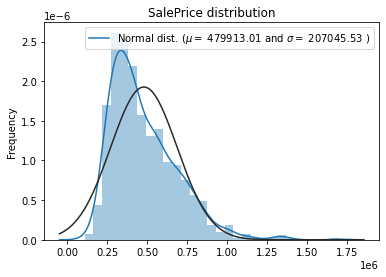

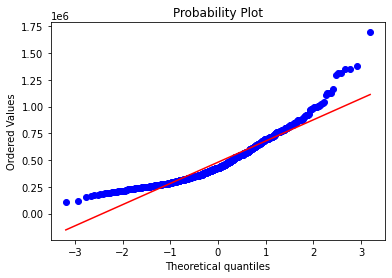

In [20]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 

sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

The distribution of the target variable is skewed. 

Perform log-transformation of the target variable in the training and test set.

c:\Users\nino\anaconda4\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 13.00 and sigma = 0.41



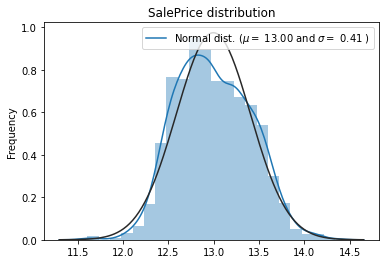

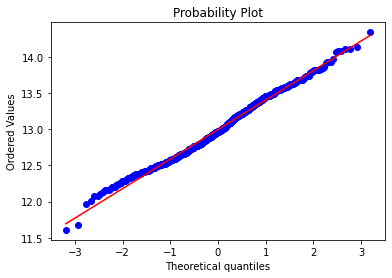

In [21]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)

#Check the new distribution 
sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

c:\Users\nino\anaconda4\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.98 and sigma = 0.34



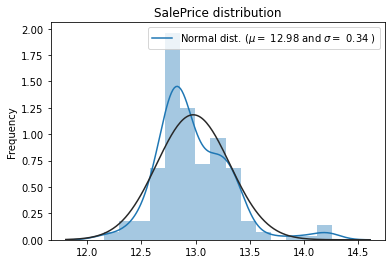

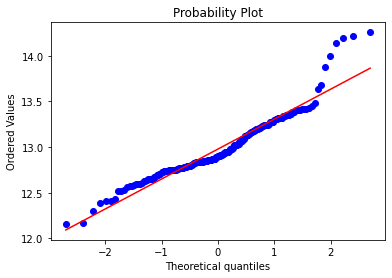

In [22]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_test = np.log1p(y_test)

#Check the new distribution 
sns.distplot(y_test , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_test)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_test, plot=plt)
plt.show()

## Modeling with network embedding - GLACE

In [23]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)


LinearRegression()

I should check for the following conditions to check what isd going wrong with the prediction of the models:
1) Class imbalance, uneven distirbution. Need to plot the distribution and ptoentially nromalize it. -- Lognormalizing this does have a signifant increase in performance of the model too.
2) High non-linearitty, then i need to use another model to see if it has the same consequence -- IT SEEMS LIKE THIS WAS THE CASE!
3) Overfitting, seems weird. Could check by taking a larger dataset or using regularization.

In [24]:
linreg.predict(X_test)

array([13.440002 , 12.925476 , 12.560181 , 12.808228 , 12.927734 ,
       13.243774 , 13.053406 , 12.636414 , 12.970276 , 12.605591 ,
       13.014709 , 13.157837 , 13.137268 , 12.838562 , 12.956909 ,
       12.675293 , 13.125549 , 13.013977 , 12.6814575, 12.784485 ,
       12.407532 , 12.766174 , 13.114929 , 13.756531 , 12.340576 ,
       13.107422 , 13.451355 , 12.736511 , 12.801819 , 12.832031 ,
       12.849976 , 13.170288 , 12.736572 , 12.704895 , 12.672424 ,
       12.865784 , 13.014832 , 12.955566 , 13.17395  , 12.94574  ,
       13.282166 , 12.986267 , 13.609741 , 13.110596 , 13.271973 ,
       12.525024 , 12.890625 , 13.044983 , 13.264404 , 13.081116 ,
       12.929321 , 12.843079 , 13.075256 , 12.854492 , 12.820068 ,
       13.285706 , 13.336853 , 12.891785 , 12.883545 , 13.059387 ,
       13.143005 , 12.709595 , 12.838013 , 12.602234 , 12.844971 ,
       12.712585 , 12.972351 , 12.738464 , 13.2855835, 12.750061 ,
       12.966736 , 12.738953 , 12.67572  , 12.847839 , 12.7182

In [25]:
linreg.score(X_test, y_test)

0.7430152150969709

In [26]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linreg, X_train, y_train, cv=5)
scores.mean()

0.7438351439406934

In [27]:
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
predictions = XGBR.predict(X_test)
XGBR.score(X_test, y_test)

0.6002532301576466

In [28]:
scores = cross_val_score(XGBR, X_train, y_train, cv=5)
scores.mean() # Need to check if this is normal without hyperparameter tuning etc. Check this in contrast to using a classical approach to estimating the model performance.
# Note also that this is a very small dataset of 1000 instances, it has trained on approx 800 and tests on 200, so it is somewhat normal that the score is low.

0.6646398675638288

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [30]:
rf.score(X_test, y_test)

0.5894580531838975

In [31]:
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores.mean()

0.6820752678748729

In [27]:
mse = mean_squared_error(y_test, y_pred)
mse

107.22547883637122

## Modelling without network embedding - raw features

Feature engineering is not included yet with regards to geospatial information like amount of houses in certain proximity.
(Currently using the dataset without zipcode)

In [32]:
base_df = pd.read_csv("BaseKC_data.csv")
base_df 

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month,day,index
0,3793500160,323000.0,0.090909,0.411765,0.309917,0.009483,0.4,0.0,0.0,0.50,...,0.895652,0.0,47.3684,-122.031,0.497076,0.028580,1.0,0.181818,0.366667,9
1,6865200140,485000.0,0.121212,0.058824,0.250000,0.005856,0.2,0.0,0.0,0.75,...,0.139130,0.0,47.6648,-122.343,0.269006,0.014299,0.0,0.363636,0.933333,17
2,5416510140,360000.0,0.121212,0.411765,0.411157,0.006979,0.4,0.0,0.0,0.50,...,0.913043,0.0,47.3608,-122.036,0.505848,0.017356,0.0,0.545455,0.300000,73
3,5104520400,390000.0,0.090909,0.411765,0.404959,0.007140,0.4,0.0,0.0,0.50,...,0.895652,0.0,47.3512,-122.008,0.485380,0.018941,0.0,1.000000,0.033333,80
4,7437100340,360000.0,0.121212,0.411765,0.311983,0.008406,0.4,0.0,0.0,0.50,...,0.800000,0.0,47.3490,-122.031,0.345029,0.023492,0.0,1.000000,0.700000,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,1931300090,610950.0,0.090909,0.529412,0.266529,0.001475,0.8,0.0,0.0,0.50,...,0.991304,0.0,47.6572,-122.346,0.277778,0.016483,0.0,0.363636,0.200000,21574
1188,7570050450,347500.0,0.090909,0.411765,0.444215,0.006594,0.4,0.0,0.0,0.50,...,0.956522,0.0,47.3452,-122.022,0.540936,0.015482,0.0,0.727273,0.300000,21589
1189,1931300412,475000.0,0.090909,0.352941,0.165289,0.000881,0.8,0.0,0.0,0.50,...,0.939130,0.0,47.6542,-122.346,0.143275,0.000865,1.0,0.272727,0.500000,21592
1190,1972201967,520000.0,0.060606,0.352941,0.235537,0.000530,0.8,0.0,0.0,0.50,...,0.921739,0.0,47.6533,-122.346,0.245614,0.001118,0.0,0.818182,1.000000,21595


In [35]:
from sklearn.model_selection import train_test_split
X = base_df.drop(["price"], axis=1)
y = base_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.predict(X_test)
linreg.score(X_test, y_test)


0.6974623963776936

In [37]:
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
predictions = XGBR.predict(X_test)
XGBR.score(X_test, y_test)

0.8191853934477693

In [39]:
from sklearn.model_selection import cross_val_score
for model in [linreg, XGBR]:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(model, scores.mean())

LinearRegression() 0.7143905047121325
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 0.7974539778845315


Predictions with log normalized target variables

In [74]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [75]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.predict(X_test)
linreg.score(X_test, y_test)

0.7112354480497862

In [76]:
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
predictions = XGBR.predict(X_test)
XGBR.score(X_test, y_test)

0.7974338493242606

In [77]:
from sklearn.model_selection import cross_val_score
for model in [linreg, XGBR]:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(model, scores.mean())

LinearRegression() 0.7869547369505678
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 0.8481229224833513
